In [2]:
import numpy as np
from modules import FEMBeam as fem
from modules.FEM_beam import draw_geometry, draw_epure

In [1]:
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline 
%config InlineBackend.figure_format = 'svg' 
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
fs = 16

# Example for static deflection of beam

### 1. Cylinder deflection

In [4]:
# analytics solve for cylinder
def f_func(r1, r2, l, fi, max_size=False):
    E = 200e9
    g = 9.81
    rho = 7850
    S = np.pi*(r2**2 - r1**2)
    q = rho*g*S*np.cos(fi)
    J_z = np.pi*(r2**4 - r1**4)/4
    def f_y(z, P=0):
        return 1/(E*J_z)*(q*l*z**3/6 - q*l**2/4*z**2 - \
                         q/24*z**4 - P*l*z**2/2 + P*z**3/6)
    def teta_y(z, P=0):
        return 1/(E*J_z)*(q*l*z**2/2 - q*l**2/2*z - q/6*z**3 - P*l*z + P*z**2/2)
        #return 1/(E*J_z)*(q*z**3/6 - q*l**3/6)
        
    def f_max(P=0):
        return -1/(E*J_z)*(q*l**4/8 + P*l**3/3)
    def teta_max(P=0):
        return -1/(6*E*J_z)*(q*l**3 + 3*P*l**2)
    
    if max_size:
        return f_max, teta_max
    return f_y, teta_y

def Moment(x, q=0, l=0, P=0):
    return q*l*x - q/2*(l**2 + x**2) - P*l + P*x

#### 1.1 Solid culinder by one FEM

In [5]:
coord = np.array([0, 10])
r1 = np.array([0.08, 0.08])
r2 = np.array([0.1, 0.1])
fi = np.pi/2
P = 0
cylinder = fem(coord, r1, r2, fi)

In [6]:
cylinder.init_y_deflect()
cylinder.init_x_deflect()

In [7]:
%%time 
cylinder.calc_y_deflect()

CPU times: total: 0 ns
Wall time: 0 ns


In [8]:
%%time
cylinder.calc_x_deflect()

CPU times: total: 0 ns
Wall time: 0 ns


In [9]:
f_max_an, teta_max_an = f_func(r1[0], r2[0], coord.sum(), fi, max_size=True)

In [10]:
teta_max_an(), cylinder.teta_max

(-9.584167991071034e-19, -9.584167991071032e-19)

In [11]:
f_max_an(), cylinder.deflect_y_max

(-7.188125993303276e-18, -7.188125993303276e-18)

In [12]:
cylinder.deflect_x

array([-1.9252125e-05,  0.0000000e+00])

In [13]:
cylinder.P

array([-8709.4561631,     0.       ])

#### 1.2 Solid cylinder by many FEM

In [25]:
N_fem = 101+1
coord = np.linspace(0, 10, N_fem)
r1 = np.full(N_fem, 0.08)
r2 = np.full(N_fem, 0.1)
fi = np.pi/4
P = np.zeros_like(coord)
P[0] = 0

In [26]:
cylinder = fem(coord, r1, r2, fi)
cylinder.init_y_deflect(P)
cylinder.init_x_deflect(P)

In [27]:
%%time 
cylinder.calc_y_deflect()

CPU times: total: 0 ns
Wall time: 997 µs


In [28]:
%%time
cylinder.calc_x_deflect()

CPU times: total: 0 ns
Wall time: 499 µs


In [29]:
f_max_an, teta_max_an = f_func(r1[0], r2[0], coord[-1], fi, max_size=True)

In [30]:
teta_max_an(-P[0]), cylinder.teta_max

(-0.011067730194919564, -0.011067730194919563)

In [31]:
f_max_an(-P[0]), cylinder.deflect_y_max

(-0.08300797646189674, -0.08300797646189666)

In [32]:
cylinder.deflect_x_max, cylinder.P[-1]

(-1.3613308139751066e-05, 0.0)

### 2. Test cone and cylinder

In [61]:
N_slice = 100
coord = np.hstack((
                np.linspace(0, 0.5, N_slice)[:-1], #np.array([0]),
                np.linspace(0.5, 0.55, N_slice)[:-1],
                np.linspace(0.55, 1.75, N_slice)[:-1],
                np.linspace(1.75, 2.5, N_slice)[:-1],
                np.linspace(2.5, 5, N_slice),
            ))
r1 = np.full(len(coord), 0.133)
r2 = np.hstack((
                np.linspace(0.25, 0.25, N_slice)[:-1],
                np.linspace(0.25, 0.23, N_slice)[:-1],
                np.linspace(0.23, 0.23, N_slice)[:-1],
                np.linspace(0.23, 0.18, N_slice)[:-1],
                np.linspace(0.18, 0.18, N_slice),
            ))
fi = 0
P = np.zeros_like(coord)
P[0] = -300*9.81

In [62]:
cylinder = fem(coord, r1, r2, fi)
cylinder.init_y_deflect(P)
cylinder.init_x_deflect()

In [63]:
%%time 
cylinder.calc_y_deflect()

CPU times: total: 15.6 ms
Wall time: 5.5 ms


In [64]:
%%time
cylinder.calc_x_deflect()

CPU times: total: 0 ns
Wall time: 2 ms


In [65]:
cylinder.deflect_y_max, cylinder.teta_max

(-0.006207771370664123, -0.0016365709813021927)

In [66]:
cylinder.deflect_y_max*1000

-6.207771370664123

### 3. Tets from CAD

### 4. Epure examples

__Deflection__

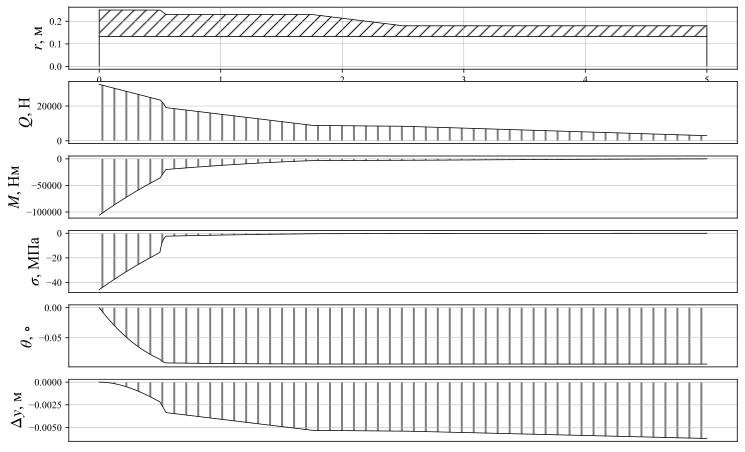

In [67]:
fig_teat, ax = plt.subplots(6, 1, figsize=(12, 8))
draw_geometry(cylinder, ax[0])

list_epure = ['Q', 'M', 'sigma_max','teta', 'deflect_y']
for i, epure in enumerate(list_epure):
    draw_epure(cylinder, ax[i+1], epure)
    ax[i+1].xaxis.set_visible(False)
plt.show()

In [73]:
fi_a = np.radians(0.1)
l = 3000

In [74]:
np.tan(fi_a) * l * 1000

5235.993072566402